In [23]:
import cv2                 
import numpy as np         
import os        

from random import shuffle 
from tqdm import tqdm      

In [24]:
# Contains 3000 Non Varying Image

# TRAIN_DIR = '/home/sauradip/Desktop/cnn-tf/data/raw-data/mix'
# TEST_DIR = '/home/sauradip/Desktop/cnn-tf/data/raw-data/mix'

# Contains 5000+ Variation IMages

TRAIN_DIR = '/home/pallab/gestures-cnn/images/resized'
TEST_DIR = '/home/pallab/gestures-cnn/images/testnew/orig'

In [25]:
IMG_SIZE = 100 # Resizing and reshaping 
LR = 1e-3 # Learning Rate is 0.001

In [26]:
MODEL_NAME = 'gesture-{}-{}.model'.format(LR, 'commit') # just so we remember which saved model is which, sizes must match

In [27]:
def label_img(img):
    word_label = img[0]
    # conversion to one-hot array [index,v-shape,fist,terminal]
   
    if word_label == 'i': return [1,0,0,0]                            
    elif word_label == 'v': return [0,1,0,0]
    elif word_label == 'f': return [0,0,1,0]
    elif word_label == 't': return [0,0,0,1]

In [28]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path , cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [29]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data


In [30]:
train_data = create_train_data()
# If i have already created the dataset ,i will just load it :
#train_data = np.load('train_data.npy')

100%|██████████| 6109/6109 [00:17<00:00, 350.96it/s]


In [31]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression


In [32]:
import tensorflow as tf
tf.reset_default_graph()
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

# 7 Layered CNN Architecture with 5 Convolutional and 2 FC Layer with Dropout and Max Pooling

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = dropout(convnet, 0.8)
print(convnet.shape)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = dropout(convnet, 0.8)
print(convnet.shape)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = dropout(convnet, 0.8)
print(convnet.shape)

convnet = conv_2d(convnet, 256, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = dropout(convnet, 0.8)
print(convnet.shape)

convnet = conv_2d(convnet, 512, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = dropout(convnet, 0.8)
print(convnet.shape)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 4, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

(?, 20, 20, 32)
(?, 4, 4, 64)
(?, 1, 1, 128)
(?, 1, 1, 256)
(?, 1, 1, 512)


In [33]:
train=[]
test=[]
train = train_data[:4000] # training data
test = train_data[4000:] # validation data

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i1[1] for i1 in train]

test_x = np.array([i2[0] for i2 in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i3[1] for i3 in test]

model.fit({'input': X}, {'targets': Y}, n_epoch=5, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=50, show_metric=True, run_id=MODEL_NAME)

model.save("/home/pallab/gestures-cnn/tfmodels/"+MODEL_NAME)
# model.save("/home/sauradip/Desktop/cnn-tf/model/"+MODEL_NAME)

Training Step: 314  | total loss: 0.59266 | time: 112.105s
| Adam | epoch: 005 | loss: 0.59266 - acc: 0.7897 -- iter: 3968/4000
Training Step: 315  | total loss: 0.58572 | time: 122.577s
| Adam | epoch: 005 | loss: 0.58572 - acc: 0.7889 | val_loss: 0.22772 - val_acc: 0.9407 -- iter: 4000/4000
--
INFO:tensorflow:/home/pallab/gestures-cnn/tfmodels/gesture-0.001-commit.model is not in all_model_checkpoint_paths. Manually adding it.


100%|██████████| 573/573 [00:01<00:00, 473.19it/s]


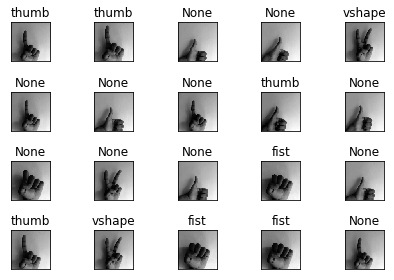

[1, 1, 4, 4, 2, 1, 4, 1, 4, 4, 3, 2, 4, 3, 4, 1, 2, 3, 3, 1] [4, 4, 5, 5, 2, 5, 5, 5, 4, 5, 5, 5, 5, 3, 5, 4, 2, 3, 3, 5]
             precision    recall  f1-score   support

          1       0.00      0.00      0.00         6
          2       1.00      0.67      0.80         3
          3       1.00      0.75      0.86         4
          4       0.25      0.14      0.18         7
          5       0.00      0.00      0.00         0

avg / total       0.44      0.30      0.36        20



/home/pallab/cvp/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pallab/cvp/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [43]:
import matplotlib.pyplot as plt
# model.load("/home/pallab/gestures-cnn/tfmodels/"+MODEL_NAME)
test_data = process_test_data()
show = 20
col = 5
fig=plt.figure()
labelss = []
predics = []
for num,data in enumerate(test_data[:show]):
    img_num = data[1]
    img_data = data[0]
    if img_num == "i":
        labelss.append(1)
    elif img_num == "v":
        labelss.append(2)
    elif img_num == "f":
        labelss.append(3)
    elif img_num == "t":
        labelss.append(4)
    
    y = fig.add_subplot((show/col),col,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = (model.predict([data])[0]).round()
    if np.array_equal((model_out),np.array([1.,0.,0.,0.])):
        str_label='index'
        predics.append(1)
    elif np.array_equal((model_out),np.array([0.,1.,0.,0.]) ): 
        str_label='vshape'
        predics.append(2)
    elif np.array_equal((model_out) , np.array([0.,0.,1.,0.])): 
        str_label='fist'
        predics.append(3)
    elif np.array_equal((model_out) , np.array([0.,0.,0.,1.])): 
        str_label='thumb'
        predics.append(4)
    else:
        str_label = "None"
        predics.append(5)
    
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

print(labelss, predics)
from sklearn.metrics import classification_report

print(classification_report(labelss, predics))

#print('Precision of the Model is '+str(precision*100) + ' %')

In [35]:
print(predics)

[]


In [53]:
model.load("/home/pallab/gestures-cnn/tfmodels/"+MODEL_NAME)

INFO:tensorflow:Restoring parameters from /home/sauradip/Desktop/cnn-tf/model/gesture-0.001-7_new_data_conv-basic.model


In [33]:
print(precision)


1.0